# 人脸区域及关键点检测

本案例使用`dlib`工具库进行人脸区域检测和人脸关键点（68个点）检测。

- 对图片中的人脸进行区域和关键点的检测
- 对视频中的人脸进行区域和关键点的检测

`dlib`官网： http://dlib.net/. `dlib`是一个机器学习工具库，类似OpenCV，里面预置了一些开发好的传统机器学习算法和深度学习算法。

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

|项目|建议填写方式|
|-|-|
|名称|自定义环境名称|
|工作环境 | Python3|
| 资源池 | 选择"公共资源池"即可 |
|类型|GPU|
|规格|GPU:1*p100, CPU:8核64GiB|
|存储配置|EVS|
|磁盘规格|5GB|

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后选择TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"face_detector"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

# 实践过程

### 数据和代码下载
运行下面代码，进行数据和代码的下载和解压

In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_face_detector/detector.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_face_detector/detector.tar"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./detector.tar")

Successfully download file modelarts-labs-bj4/notebook/DL_face_detector/detector.tar from OBS to local ./detector.tar


In [2]:
!tar -xf detector.tar

### 安装依赖

安装`dlib`包

In [3]:
!pip install dlib==19.17.0

    100% |████████████████████████████████| 3.4MB 64.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for dlib ... done
  Stored in directory: /home/ma-user/.cache/pip/wheels/08/5a/4b/bcf41d6cd899b5eb985f10fb94ef90439fa1c99369f3ec7db5
Successfully built dlib
You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 人脸区域检测

In [4]:
from PIL import Image
import dlib

### 获取人脸区域检测器

获取基于神经网络CNN的人脸区域检测器，并加载预训练模型。

`dlib.cnn_face_detection_model_v1()`方法介绍: http://dlib.net/cnn_face_detector.py.html

In [5]:
cnn_face_detector = dlib.cnn_face_detection_model_v1("./models/detector.dat")

### 打开测试文件

读取测试图片，可以换成其他图片进行测试

In [6]:
image = dlib.load_rgb_image("./test.jpg")

### 检测

检测，得到图片中人脸的位置。返回人脸区域左上角和又下角的坐标。

In [7]:
dets = cnn_face_detector(image, 1)

### 打印检测结果

In [8]:
dets

mmod_rectangles[[(213, 199) (355, 341)]]

In [9]:
print("Number of faces detected: {}".format(len(dets)))
for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(
        i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

Number of faces detected: 1
Detection 0: Left: 213 Top: 199 Right: 355 Bottom: 341 Confidence: 1.0674526691436768


### 绘制人脸区域检测结果

In [10]:
rects = dlib.rectangles()
rects.extend([d.rect for d in dets])

In [11]:
rects

rectangles[[(213, 199) (355, 341)]]

In [19]:
import cv2
res_img = cv2.rectangle(image, (rects[0].left(), rects[0].top()), (rects[0].right(), rects[0].bottom()), 0, 1)

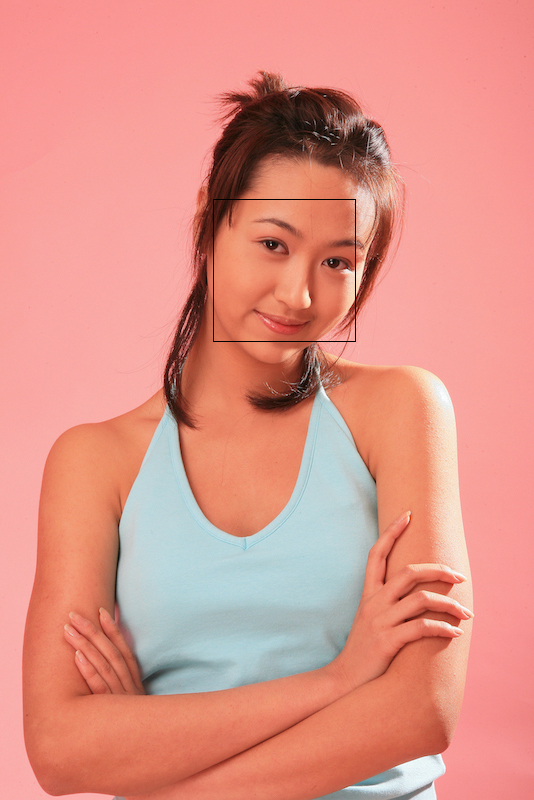

In [20]:
Image.fromarray(res_img)

## 人脸关键点检测

人脸关键点检测，依赖人脸区域检测输出的人脸位置，然后在人脸区域内检测人脸关键点。会输出68个人脸关键点。

### 检测人脸区域

获取人脸区域检测器

`dlib.get_frontal_face_detector()`方法返回基于[HoG (Histogram of Oriented Gradients)](https://zh.wikipedia.org/wiki/%E6%96%B9%E5%90%91%E6%A2%AF%E5%BA%A6%E7%9B%B4%E6%96%B9%E5%9B%BE)的人脸区域检测器。`HoG`是图像处理领域用于目标检测的特征描述器。

In [21]:
detector = dlib.get_frontal_face_detector()

检测人脸区域

In [22]:
dets = detector(image, 1)

### 检测人脸关键点

获取基于神经网络的人脸关键点检测模型，并加载预训练模型

In [23]:
predictor_kp = dlib.shape_predictor("./models/shape_predictor_68_face_landmarks.dat")

人脸关键点检测，检测人脸的68个关键点。

In [24]:
for k, d in enumerate(dets): # 遍历每个人脸框
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        k, d.left(), d.top(), d.right(), d.bottom()))
    res_img = cv2.rectangle(res_img,( d.left(), d.top()), (d.right(), d.bottom()), 0, 1)
    # 检测人脸关键点
    shape = predictor_kp(image, d)
    print("Point 0: {}, Point 1: {} ...".format(shape.part(0), shape.part(1)))

Detection 0: Left: 218 Top: 202 Right: 373 Bottom: 356
Point 0: (221, 219), Point 1: (216, 241) ...


### 显示关键点检测结果

绘制关键点

In [25]:
for i in range(68):
    res_img = cv2.circle(res_img,(shape.part(i).x,shape.part(i).y), 1, 255, 4)

显示人脸区域和68个关键点的检测结果

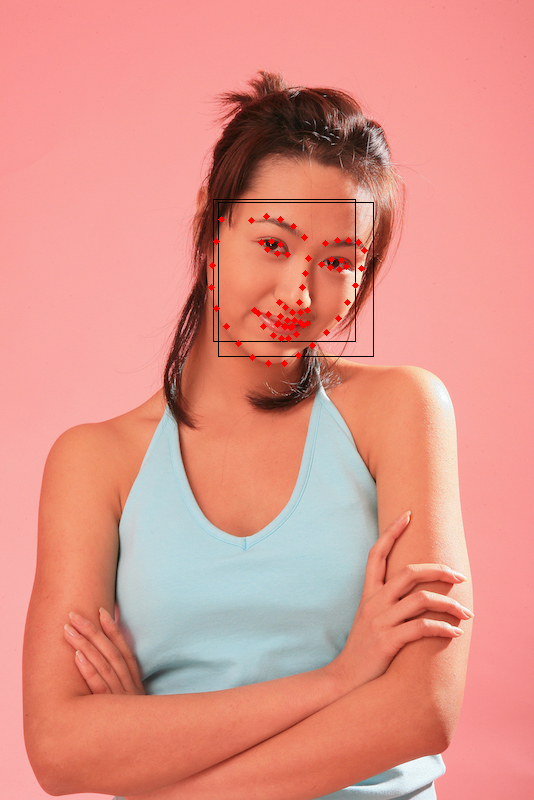

In [26]:
Image.fromarray(res_img)

## 视频人脸检测

使用OpenCV读取一段视频，然后逐帧显示视频。

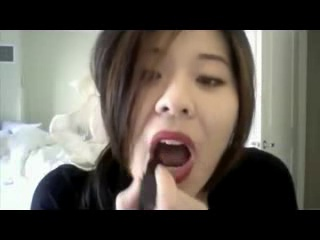

In [20]:
from IPython.display import clear_output, Image, display, HTML
import time
import cv2
import base64
import numpy as np

# 原视频，视频来源：UCF-101数据集
video_name = "./face_0.avi"

def arrayShow(img):
    _,ret = cv2.imencode('.jpg', img)
    return Image(data=ret)

# 打开一个视频流
cap = cv2.VideoCapture(video_name)

while True:
    try:
        clear_output(wait=True) # 清除之前的显示
        ret, frame = cap.read() # 读取一帧图片
        if ret:
            tmp = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # 转换色彩模式
            img = arrayShow(frame)
            display(img) # 显示图片
            time.sleep(0.05) # 线程睡眠一段时间再处理下一帧图片
        else:
            break
    except KeyboardInterrupt:
        cap.release()
cap.release()

### 人脸关键点检测函数

使用`dlib`集成的深度学习模型，检测人脸的68个关键点。

In [21]:
def keypoint_detector(image):
    global res_img
    detector = dlib.get_frontal_face_detector() # 获取人脸区域检测器
    dets = detector(image, 1) # 检测人脸区域
    predictor_kp = dlib.shape_predictor("./models/shape_predictor_68_face_landmarks.dat") # 加载人脸关键点检测模型
    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        res_img = cv2.rectangle(image,( d.left(), d.top()), (d.right(), d.bottom()), 0, 1)
        shape = predictor_kp(image, d) # 检测人脸关键点
        for i in range(68):
            res_img = cv2.circle(image,(shape.part(i).x,shape.part(i).y), 1, 255, 2)
    return res_img

### 检测视频中的人脸关键点，并显示

Detection 0: Left: 110 Top: 53 Right: 239 Bottom: 182


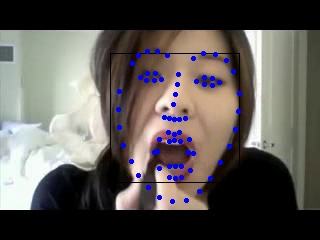

In [22]:
def arrayShow(img):
    _,ret = cv2.imencode('.jpg', img) 
    return Image(data=ret) 

cap = cv2.VideoCapture(video_name)

while True:
    try:
        clear_output(wait=True)
        ret, frame = cap.read()
        if ret:
            res_img = keypoint_detector(frame)
            img = arrayShow(res_img)
            display(img)
            time.sleep(0.01)
        else:
            break
    except KeyboardInterrupt:
        cap.release()
cap.release()

## 小结

* 使用dlib检测人脸区域，基于传统方式(`HoG`)和深度神经网络方式。
* 使用dlib检测人脸关键点，基于深度神经网络方式。
* 使用OpenCV对视频抽帧，并检测人脸。